# Classification of SVHN using Transfer Learning from pre-trained MNIST CNN

---



## The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 0.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
- Comes in two formats:
  1. Original images with character level bounding boxes.
  2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

- The dataset that we will be using in this notebook contains 42000 training samples and 18000 testing samples

Firstly, let's select TensorFlow version 2.x in colab

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.15.0'

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

As we are using google colab, we need to mount the google drive to load the data file

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Add path to the folder where your dataset is present

In [4]:
project_path = '/content/drive/My Drive/SVHN_single_grey1.h5'
# '/content/drive/My Drive/CV/AIML 2.0 Class/Week2/'

Let's load the dataset now

In [6]:
import h5py

# Open the file as readonly
# h5f = h5py.File(project_path + 'SVHN_single_grey1.h5', 'r')
h5f = h5py.File('/content/drive/MyDrive/Colab Notebooks/traffic/SVHN_single_grey1.h5','r')


# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
# Close this file
h5f.close()

### Print the shape of training and testing data

In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (42000, 32, 32)
y_train shape: (42000,)
X_test shape: (18000, 32, 32)
y_test shape: (18000,)


### Let's check out the dataset

7 2 9 0 9 1 8 4 4 8 
9 1 4 3 5 8 6 5 5 0 
6 5 8 3 2 0 1 9 5 2 
8 9 1 0 9 5 3 3 7 6 
4 2 4 9 6 7 8 8 3 5 
3 7 1 4 8 1 4 2 9 0 
1 5 9 9 2 2 2 4 8 9 
8 3 8 4 5 2 8 6 4 5 
4 2 8 2 4 0 9 9 6 3 
2 7 5 0 7 6 9 8 7 2 


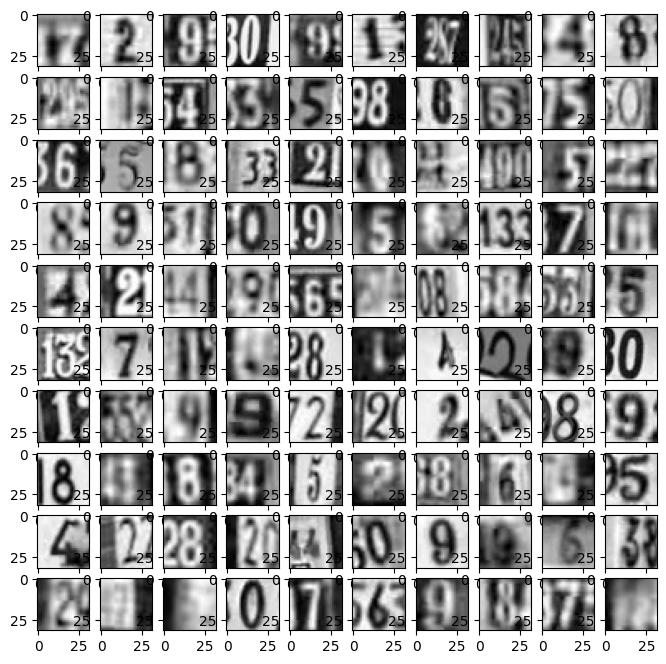

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

columns = 10
rows = 10

fig=plt.figure(figsize=(8, 8))

for i in range(1, columns*rows + 1):
    img = X_test[i]
    fig.add_subplot(rows, columns, i)
    print (y_test[i], end=' ')
    if i % columns == 0:
      print ("")
    plt.imshow(img, cmap='gray')

plt.show()

### Resize all the train and test inputs to 28X28, to match with MNIST CNN model's input size



In [9]:
# Importing OpenCV module for the resizing function
import cv2
import numpy as np

# Create a resized dataset for training and testing inputs with corresponding size
# Here we are resizing it to 28X28 (same input size as MNIST)
X_train_resized = np.zeros((X_train.shape[0], 28, 28))
for i in range(X_train.shape[0]):
  #using cv2.resize to resize each train example to 28X28 size using Cubic interpolation
  X_train_resized[i,:,:] = cv2.resize(X_train[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

X_test_resized = np.zeros((X_test.shape[0], 28, 28))
for i in range(X_test.shape[0]):
  #using cv2.resize to resize each test example to 28X28 size using Cubic interpolation
  X_test_resized[i,:,:] = cv2.resize(X_test[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

# We don't need the original dataset anynmore so we can clear up memory consumed by original dataset
del(X_train, X_test)

### Reshape train and test sets into compatible shapes
- Sequential model in tensorflow.keras expects data to be in the format (n_e, n_h, n_w, n_c)
- n_e= number of examples, n_h = height, n_w = width, n_c = number of channels
- do not reshape labels

In [10]:
X_train = X_train_resized.reshape(X_train_resized.shape[0], 28, 28, 1)
X_test = X_test_resized.reshape(X_test_resized.shape[0], 28, 28, 1)

We can delete X_train_resized and X_test_resized variables as we are going to use X_train and X_test variables going further

In [11]:
del(X_train_resized, X_test_resized)

### Normalize data
- we must normalize our data as it is always required in neural network models
- we can achieve this by dividing the RGB codes with 255 (which is the maximum RGB code minus the minimum RGB code)
- normalize X_train and X_test
- make sure that the values are float so that we can get decimal points after division

In [12]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

### Print shape of data and number of images
- print shape of X_train
- print number of images in X_train
- print number of images in X_test

In [13]:
print("X_train shape:", X_train.shape)
print("Images in X_train:", X_train.shape[0])
print("Images in X_test:", X_test.shape[0])

X_train shape: (42000, 28, 28, 1)
Images in X_train: 42000
Images in X_test: 18000


### One-hot encode the class vector
- convert class vectors (integers) to binary class matrix
- convert y_train and y_test
- number of classes: 10
- we are doing this to use categorical_crossentropy as loss

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Let's see one example after one-hot encoding

Label:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


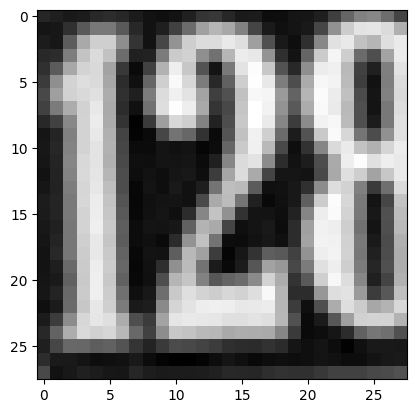

In [15]:
print("Label: ", y_train[0])
plt.imshow(X_train[0].reshape(28,28), cmap='gray')

### Building the CNN
- Define the layers of model with same size as the CNN used for MNIST Classification

### Initialize a sequential model
- define a sequential model
- add 2 convolutional layers
    - no of filters in first layer: 32
    - no of filters in second layer: 64
    - kernel size: 3x3
    - activation: "relu"
    - input shape: (28, 28, 1) for first layer
- add a max pooling layer of size 2x2
- add a dropout layer
    - dropout layers fight with the overfitting by disregarding some of the neurons while training
    - use dropout rate 0.2
- flatten the data
    - add Flatten later
    - flatten layers flatten 2D arrays to 1D array before building the fully connected layers
- add 2 dense layers
    - number of neurons in first layer: 128
    - number of neurons in last layer: number of classes
    - activation function in first layer: relu
    - activation function in last layer: softmax
    - we may experiment with any number of neurons for the first Dense layer; however, the final Dense layer must have neurons equal to the number of output classes

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense

# Initialize the model
model = Sequential()

# Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'relu'
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))

# Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'relu'
model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))

# Add a MaxPooling Layer of size 2X2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Apply Dropout with 0.2 probability
model.add(Dropout(rate=0.2))

# Flatten the layer
model.add(Flatten())

# Add Fully Connected Layer with 128 units and activation function as 'relu'
model.add(Dense(128, activation="relu"))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model.add(Dense(10, activation="softmax"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Make only dense layers trainable
- freeze the initial convolutional layer weights and train only the dense (FC) layers
- set trainalble = False for all layers other than Dense layers

In [17]:
for layers in model.layers:
    if('dense' not in layers.name):
        layers.trainable = False
    if('dense' in layers.name):
        print(layers.name + ' is trained')

dense is trained
dense_1 is trained


### Load pre-trained weights from MNIST CNN model
- load the file named `cnn_mnist_weights.h5`

In [22]:
import os
print(os.listdir())


['.config', 'drive', 'sample_data']


In [23]:
model.save_weights('cnn_mnist_weights.h5')


In [24]:
model.load_weights('cnn_mnist_weights.h5')
#model.load_weights('/path/to/your/file/cnn_mnist_weights.h5')


### Compile the model
- loss: "categorical_crossentropy"
- metrics: "accuracy"
- optimizer: "adam"

In [25]:
# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

Let's evaluate this model

In [26]:
model.evaluate(X_test, y_test)

563/563 [==============================] - 3s 5ms/step - loss: 2.3046 - accuracy: 0.0969


[2.304577589035034, 0.09688889235258102]

### Training the CNN

Fit the model to the SVHN dataset
- Use early stopping
- fit the model
    - give train data - training features and labels
    - batch size: 32
    - epochs: 10
    - give validation data - testing features and labels

In [27]:
# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, min_delta=0.01)

# Fit the model
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
1313/1313 [==============================] - 16s 12ms/step - loss: 2.3041 - accuracy: 0.1011 - val_loss: 2.3028 - val_accuracy: 0.0955
Epoch 2/10
1313/1313 [==============================] - 15s 11ms/step - loss: 2.3028 - accuracy: 0.1004 - val_loss: 2.3030 - val_accuracy: 0.0955
Epoch 3/10
1313/1313 [==============================] - 16s 12ms/step - loss: 2.3028 - accuracy: 0.1007 - val_loss: 2.3028 - val_accuracy: 0.0955


### Final loss and accuracy

In [28]:
model.evaluate(X_test, y_test)

563/563 [==============================] - 4s 7ms/step - loss: 2.3028 - accuracy: 0.0955


[2.302769184112549, 0.09549999982118607]

### Visualizing some predictions

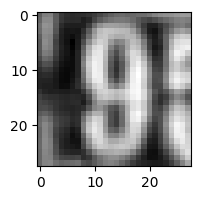

1/1 [==============================] - 0s 94ms/step
Preiction for above image:  3


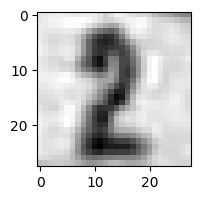

1/1 [==============================] - 0s 24ms/step
Preiction for above image:  3


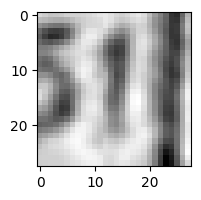

1/1 [==============================] - 0s 32ms/step
Preiction for above image:  3


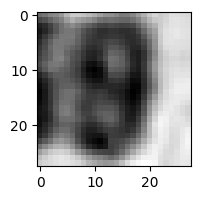

1/1 [==============================] - 0s 30ms/step
Preiction for above image:  3


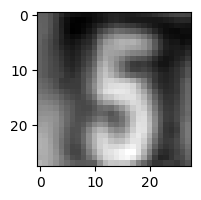

1/1 [==============================] - 0s 25ms/step
Preiction for above image:  3


In [29]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[3].reshape(28,28),cmap="gray")
plt.show()
print("Preiction for above image: ", np.argmax(model.predict(X_test[3].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(X_test[2].reshape(28,28),cmap="gray")
plt.show()
print("Preiction for above image: ", np.argmax(model.predict(X_test[2].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(X_test[33].reshape(28,28),cmap="gray")
plt.show()
print("Preiction for above image: ", np.argmax(model.predict(X_test[33].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(X_test[59].reshape(28,28),cmap="gray")
plt.show()
print("Preiction for above image: ", np.argmax(model.predict(X_test[59].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(X_test[36].reshape(28,28),cmap="gray")
plt.show()
print("Preiction for above image: ", np.argmax(model.predict(X_test[36].reshape(1,28,28,1))))




### Saving the CNN
- Save the trained weights and model in h5 files

In [30]:
#Set the path where you want to store the model and weights
model.save('cnn_svhn.h5')
model.save_weights('cnn_svhn_weights.h5')